# Run data from simulation 1 and make validation plots

Stephen Fleming

2023.06.27

Small test using a tiny simulation

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cellcap.scvi_module import CellCap
from cellcap.validation.plot import plot_adversarial_classifier_roc, plot_ard_parameters, plot_program_usage

/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [3]:
sc.set_figure_params(scanpy=True, vector_friendly=True)

# Data

In [4]:
adata = sc.read_h5ad('data/simulation_data1.h5ad')
adata.layers['counts'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 6000 × 1000
    obs: 'State', 'Pseudotime', 'Condition', 'batch'
    layers: 'counts'

In [5]:
adata.obs.head()

,State,Pseudotime,Condition,batch
0-0,A,0.000000,Control,0
1-0,A,0.000500,Control,0
2-0,A,0.001001,Control,0
3-0,A,0.001501,Control,0
4-0,A,0.002001,Control,0


In [6]:
perturbation_key = 'Condition'

## Exploration

In [7]:
pd.crosstab(adata.obs[perturbation_key], adata.obs['batch'], dropna=False, margins=True)

batch,0,1,2,All
Condition,,,,
Control,2000,0,0,2000
Perturbation1,0,2000,0,2000
Perturbation2,0,0,2000,2000
All,2000,2000,2000,6000


In [8]:
pd.crosstab(adata.obs[perturbation_key], adata.obs['State'], dropna=False, margins=True)

State,A,All
Condition,,
Control,2000,2000
Perturbation1,2000,2000
Perturbation2,2000,2000
All,6000,6000


# Model

## Setup

In [9]:
# for now we are using adata.obsm slots

assert 'control' in adata.obs[perturbation_key].str.lower().values, \
    f'adata.obs["{perturbation_key}"] does not contain "control" or "Control" '

adata.obsm['X_donor'] = pd.get_dummies(adata.obs['State']).to_numpy().astype(float)
adata.obsm['X_target'] = pd.get_dummies(
    (adata.obs[perturbation_key]
     .str.lower()
     .replace(to_replace='control', value=np.nan))
).to_numpy().astype(float)

adata

AnnData object with n_obs × n_vars = 6000 × 1000
    obs: 'State', 'Pseudotime', 'Condition', 'batch'
    obsm: 'X_donor', 'X_target'
    layers: 'counts'

In [10]:
adata.obsm['X_target'].sum(axis=0)

array([2000., 2000.])

In [11]:
adata.obs[perturbation_key].value_counts()

Condition
Control          2000
Perturbation1    2000
Perturbation2    2000
Name: count, dtype: int64

In [12]:
CellCap.setup_anndata(adata, layer='counts', target_key='X_target', donor_key='X_donor')

INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [13]:
n_response_programs = 15

cellcap = CellCap(
    adata, 
    n_latent=50,  # 20, 
    n_layers=3,  # 3,
    n_drug=adata.obs[perturbation_key].nunique() - 1, 
    n_donor=adata.obs['State'].nunique(), 
    gene_likelihood='nb', 
    n_prog=n_response_programs,
)

## Train

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 50/50: 100%|███████████| 50/50 [00:30<00:00,  1.69it/s, v_num=1, train_loss_step=7.2e+3, train_loss_epoch=1.94e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|███████████| 50/50 [00:30<00:00,  1.62it/s, v_num=1, train_loss_step=7.2e+3, train_loss_epoch=1.94e+4]
50 epochs


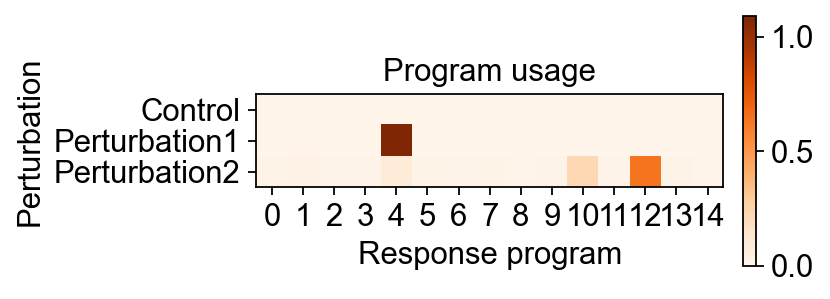

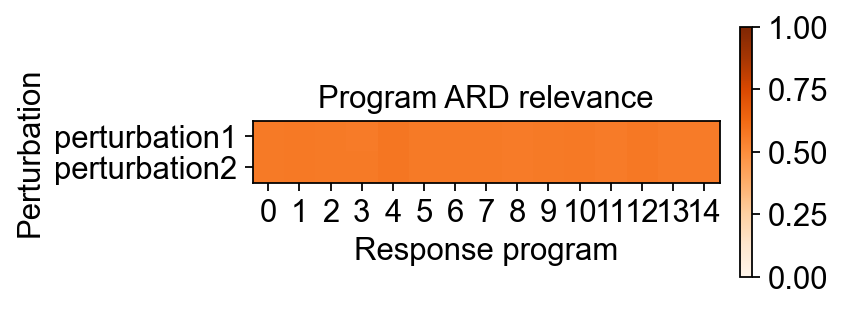

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 50/50: 100%|██████████| 50/50 [00:31<00:00,  1.62it/s, v_num=1, train_loss_step=6.34e+3, train_loss_epoch=1.74e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:31<00:00,  1.56it/s, v_num=1, train_loss_step=6.34e+3, train_loss_epoch=1.74e+4]
100 epochs


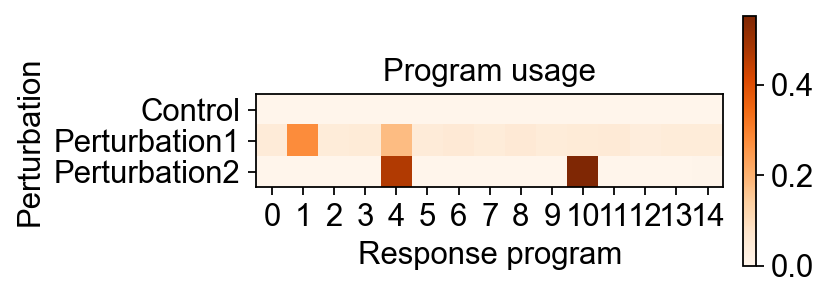

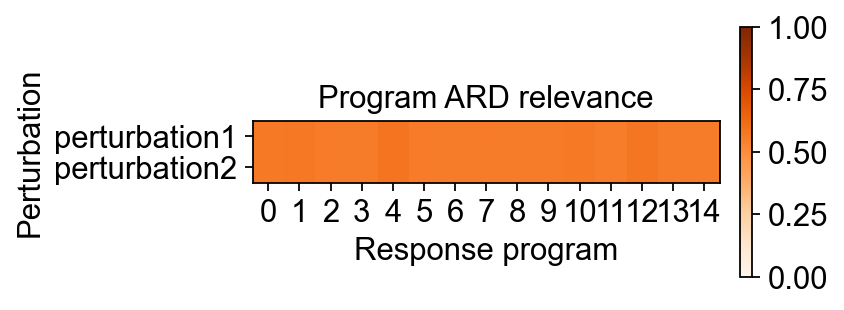

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 50/50: 100%|███████████| 50/50 [00:32<00:00,  1.61it/s, v_num=1, train_loss_step=7.01e+3, train_loss_epoch=1.9e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|███████████| 50/50 [00:32<00:00,  1.53it/s, v_num=1, train_loss_step=7.01e+3, train_loss_epoch=1.9e+4]
150 epochs


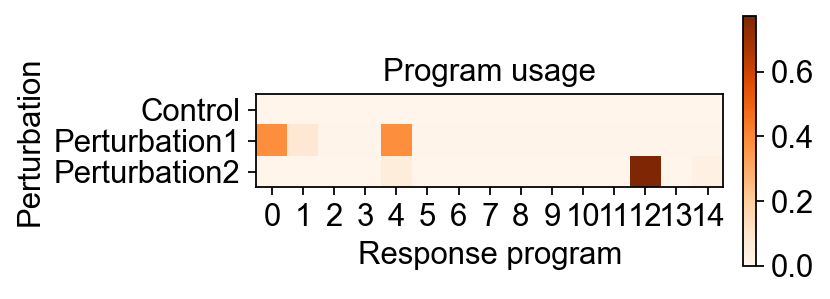

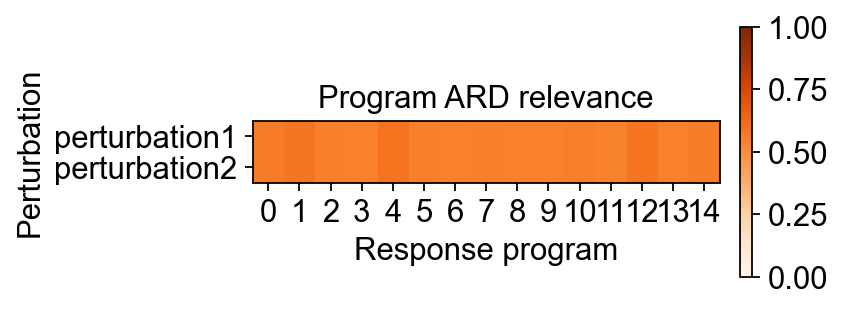

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 50/50: 100%|██████████| 50/50 [00:33<00:00,  1.64it/s, v_num=1, train_loss_step=5.85e+3, train_loss_epoch=1.51e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:33<00:00,  1.50it/s, v_num=1, train_loss_step=5.85e+3, train_loss_epoch=1.51e+4]
200 epochs


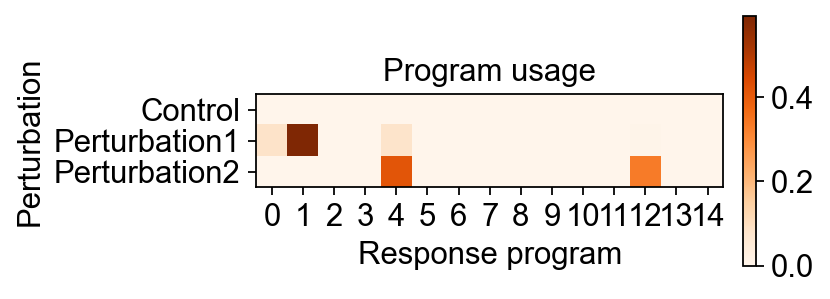

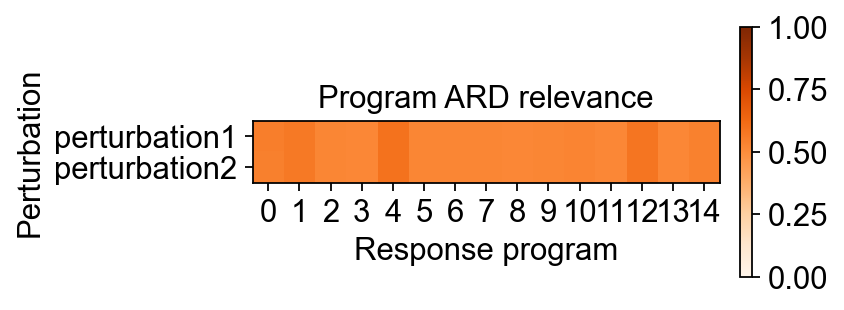

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 50/50: 100%|██████████| 50/50 [00:34<00:00,  1.45it/s, v_num=1, train_loss_step=5.79e+3, train_loss_epoch=1.59e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:34<00:00,  1.46it/s, v_num=1, train_loss_step=5.79e+3, train_loss_epoch=1.59e+4]
250 epochs


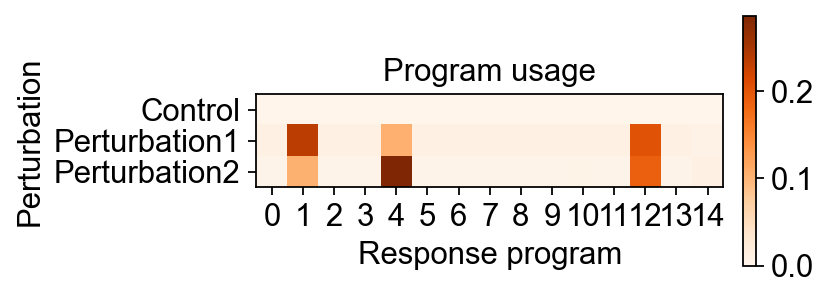

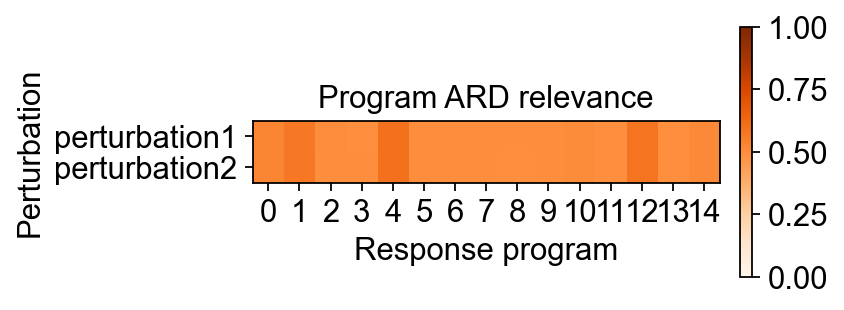

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 50/50: 100%|██████████| 50/50 [00:34<00:00,  1.51it/s, v_num=1, train_loss_step=5.55e+3, train_loss_epoch=1.52e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:34<00:00,  1.46it/s, v_num=1, train_loss_step=5.55e+3, train_loss_epoch=1.52e+4]
300 epochs


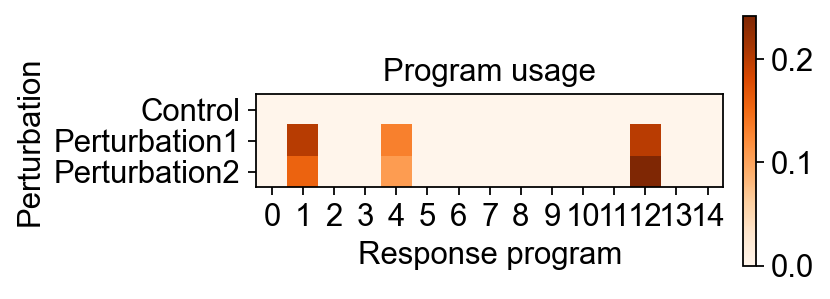

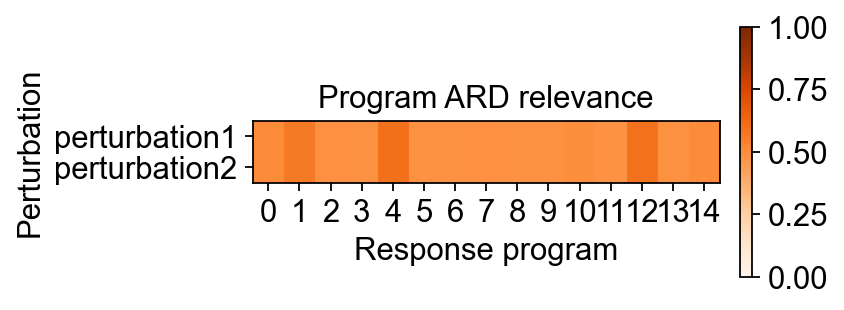

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 50/50: 100%|██████████| 50/50 [00:34<00:00,  1.58it/s, v_num=1, train_loss_step=5.21e+3, train_loss_epoch=1.36e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:34<00:00,  1.47it/s, v_num=1, train_loss_step=5.21e+3, train_loss_epoch=1.36e+4]
350 epochs


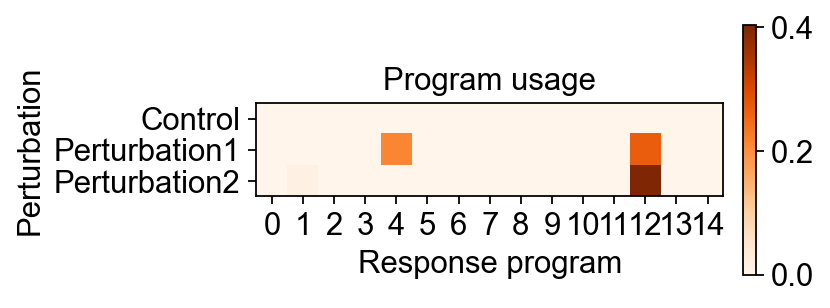

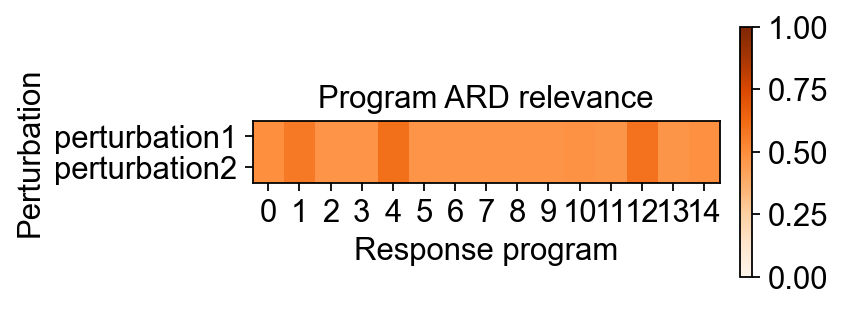

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 50/50: 100%|██████████| 50/50 [00:33<00:00,  1.58it/s, v_num=1, train_loss_step=5.53e+3, train_loss_epoch=1.49e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:33<00:00,  1.51it/s, v_num=1, train_loss_step=5.53e+3, train_loss_epoch=1.49e+4]
400 epochs


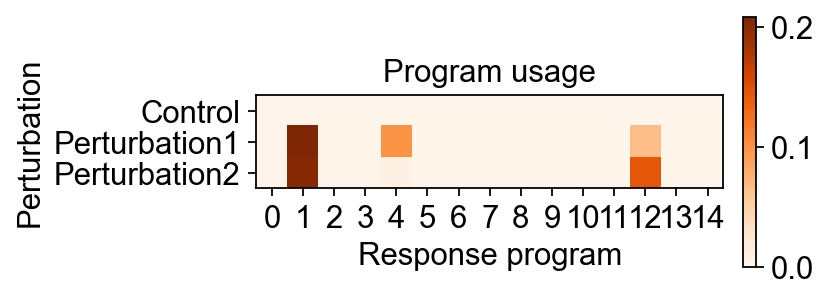

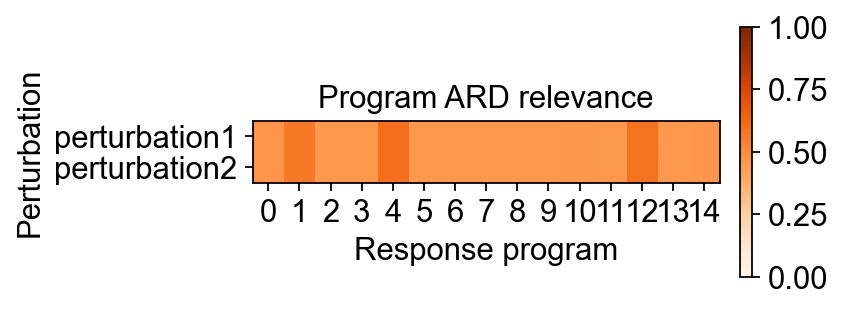

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 50/50: 100%|███████████| 50/50 [00:34<00:00,  1.54it/s, v_num=1, train_loss_step=5.7e+3, train_loss_epoch=1.55e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|███████████| 50/50 [00:34<00:00,  1.47it/s, v_num=1, train_loss_step=5.7e+3, train_loss_epoch=1.55e+4]
450 epochs


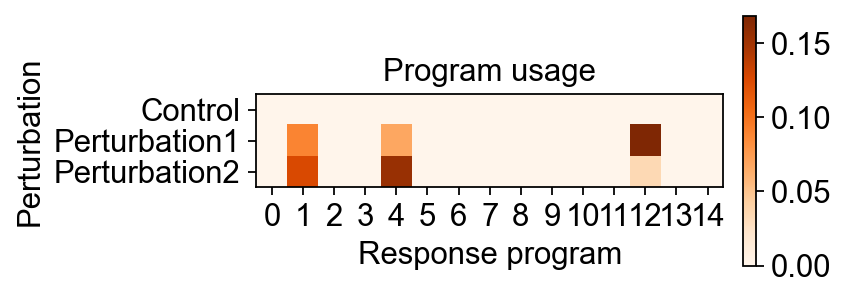

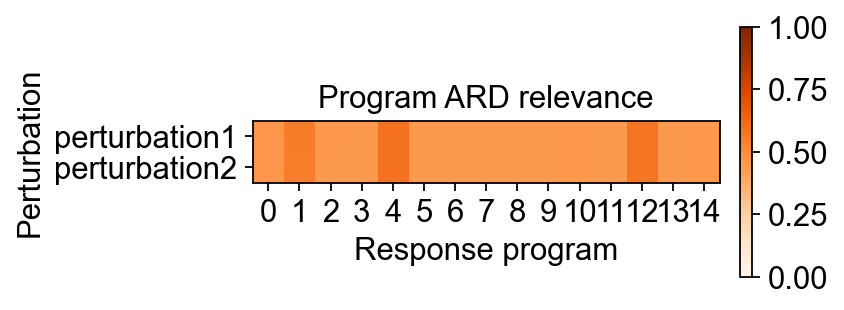

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 50/50: 100%|██████████| 50/50 [00:32<00:00,  1.62it/s, v_num=1, train_loss_step=5.23e+3, train_loss_epoch=1.43e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s, v_num=1, train_loss_step=5.23e+3, train_loss_epoch=1.43e+4]
500 epochs


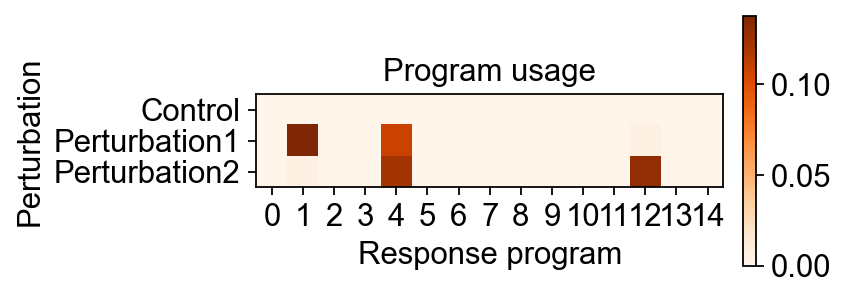

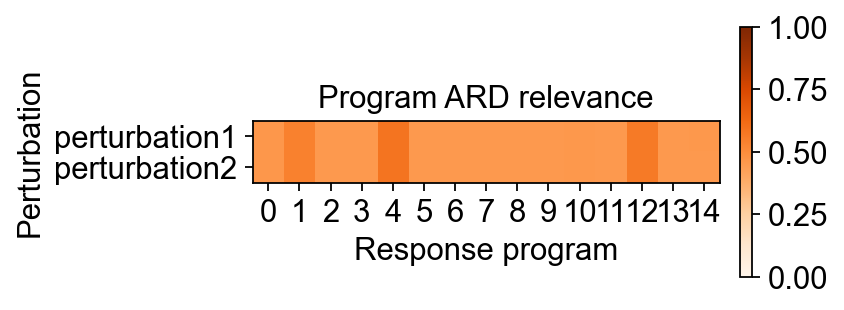

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 67/500:  13%|█       | 67/500 [00:46<04:59,  1.45it/s, v_num=1, train_loss_step=5.26e+3, train_loss_epoch=1.45e+4]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 1643.842. Signaling Trainer to stop.


In [14]:
for i in range(10):
    cellcap.train(max_epochs=50, batch_size=1024)
    
    print(f'{(i + 1) * 50} epochs')
    
    plot_program_usage(
        cellcap=cellcap,
        adata=adata,
        perturbation_key=perturbation_key,
    )
    plt.show()
    
    plot_ard_parameters(
        cellcap=cellcap,
        adata=adata,
        perturbation_key=perturbation_key,
    )
    plt.show()


cellcap.train(max_epochs=500, batch_size=1024)

In [15]:
cellcap.history.keys()

dict_keys(['validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'adv_loss_validation', 'kl_divergence_u_mean_validation', 'b_q_0_validation', 'b_q_1_validation', 'b_q_2_validation', 'b_q_3_validation', 'b_q_4_validation', 'b_q_5_validation', 'b_q_6_validation', 'b_q_7_validation', 'b_q_8_validation', 'b_q_9_validation', 'b_q_10_validation', 'b_q_11_validation', 'b_q_12_validation', 'b_q_13_validation', 'b_q_14_validation', 'c_pq_0_validation', 'c_pq_1_validation', 'c_pq_2_validation', 'c_pq_3_validation', 'c_pq_4_validation', 'c_pq_5_validation', 'c_pq_6_validation', 'c_pq_7_validation', 'c_pq_8_validation', 'c_pq_9_validation', 'c_pq_10_validation', 'c_pq_11_validation', 'c_pq_12_validation', 'c_pq_13_validation', 'c_pq_14_validation', 'c_pq_15_validation', 'c_pq_16_validation', 'c_pq_17_validation', 'c_pq_18_validation', 'c_pq_19_validation', 'c_pq_20_validation', 'c_pq_21_validation', 'c_pq_22_validation', 'c_pq_23_va

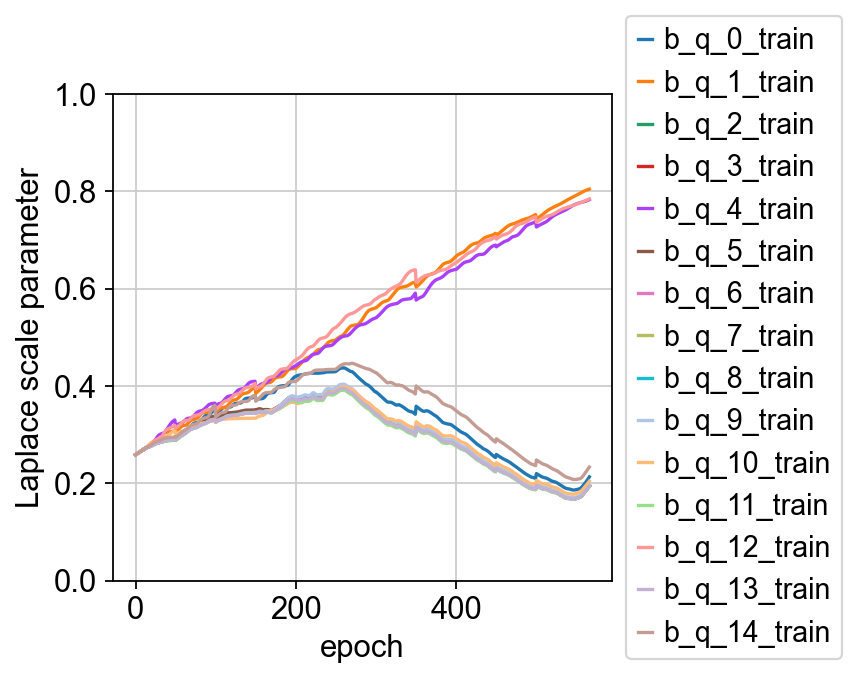

In [16]:
pd.concat([cellcap.history[k] for k in cellcap.history.keys() 
           if (k.startswith('b_q_') and k.endswith('_train'))]).plot()
plt.ylabel('Laplace scale parameter')
plt.ylim([0, 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

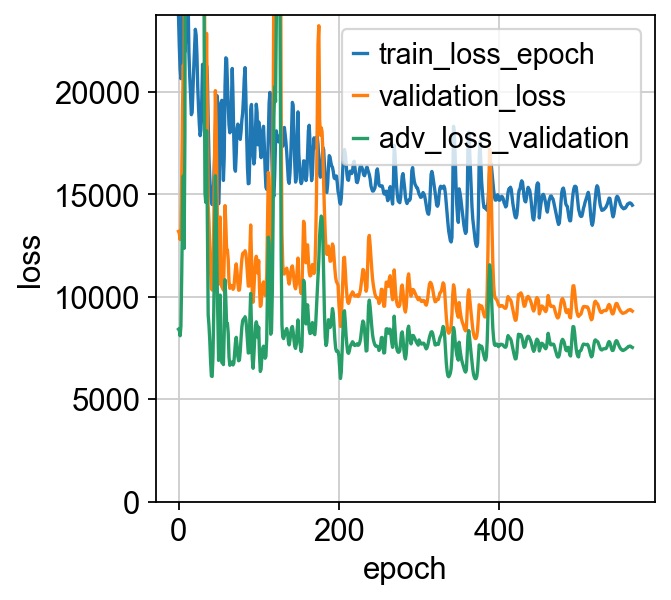

In [17]:
pd.concat([cellcap.history[k] for k in ['train_loss_epoch', 'validation_loss', 'adv_loss_validation']]).plot()
plt.ylabel('loss')
plt.ylim([0, np.quantile(cellcap.history['train_loss_epoch'], q=0.9) * 1.25])
plt.show()

# Output exploration

Get latent vector and visualization

In [18]:
import gc
gc.collect()

83003

## Program usage

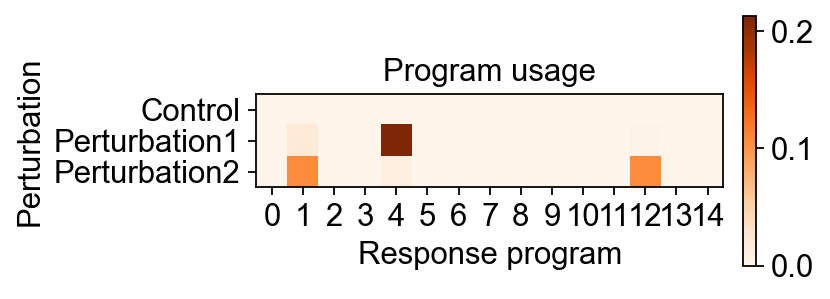

In [19]:
# how much is each program used by each perturbation?

df_usage = plot_program_usage(
    cellcap=cellcap,
    adata=adata,
    perturbation_key=perturbation_key,
)

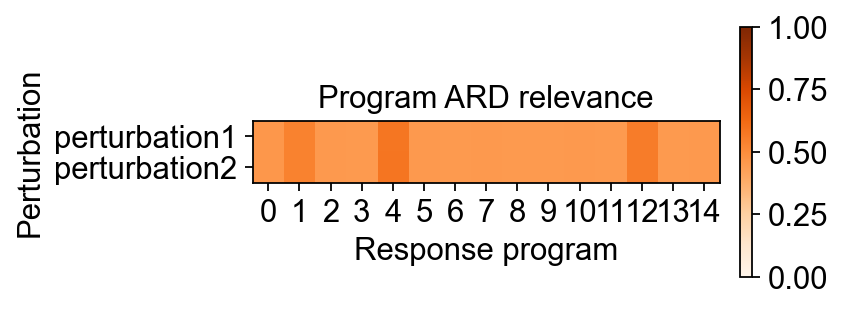

In [20]:
# which programs does ARD "turn off"?

df_ard = plot_ard_parameters(
    cellcap=cellcap,
    adata=adata,
    perturbation_key=perturbation_key,
)

In [21]:
df_ard

{'global': array([0.20678245, 0.7635908 , 0.1849662 , 0.18513882, 0.7435883 ,
        0.18539727, 0.18495457, 0.1861252 , 0.18475485, 0.18826811,
        0.19482571, 0.18376072, 0.7505288 , 0.18498412, 0.23286201],
       dtype=float32),
 'local': array([[0.45786914, 0.53827876, 0.45058694, 0.44868904, 0.5770003 ,
         0.4493714 , 0.44919476, 0.44981784, 0.44864973, 0.44832906,
         0.45205036, 0.44777113, 0.5565424 , 0.44844872, 0.4503408 ],
        [0.4576889 , 0.5376355 , 0.45024097, 0.4486972 , 0.5781524 ,
         0.4492934 , 0.44894418, 0.44953737, 0.44847733, 0.4481097 ,
         0.4517644 , 0.447695  , 0.55631906, 0.44819042, 0.4501067 ]],
       dtype=float32)}

## Basal cell state

In [22]:
z = cellcap.get_latent_embedding(adata)
z.shape

(6000, 50)

In [23]:
adata.obsm['X_basal'] = z

In [24]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_basal', random_state=0, metric='cosine')
sc.tl.umap(adata, min_dist=0.15)#,method='rapids')

/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-pac

/Users/sfleming/opt/anaconda3/envs/pert/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


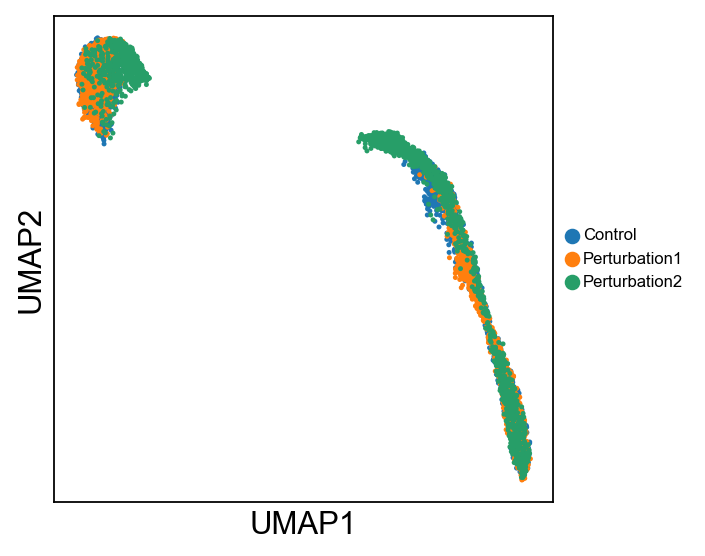

In [25]:
sc.pl.umap(adata, color='Condition', title='', legend_fontsize=7.5)

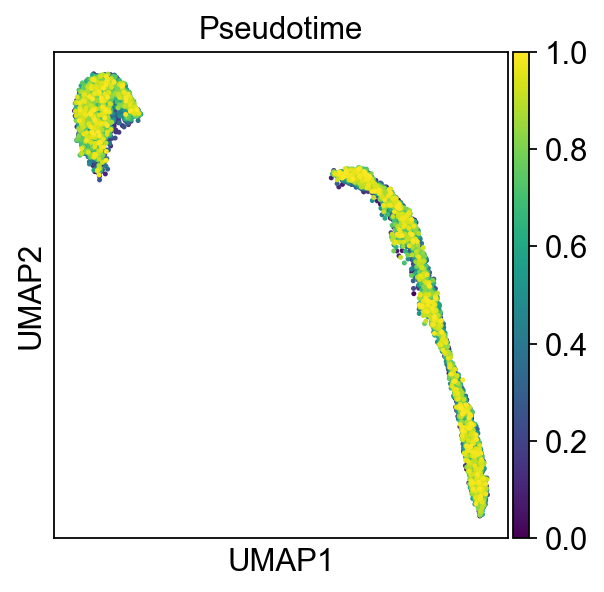

In [26]:
sc.pl.umap(adata, color='Pseudotime', legend_fontsize=7.5)

### Classifier accuracy

Want a classifier that uses the basal state to predict perturbation to be very poor.

Control (AUC = 0.7179)
Perturbation1 (AUC = 0.8145)
Perturbation2 (AUC = 0.8544)


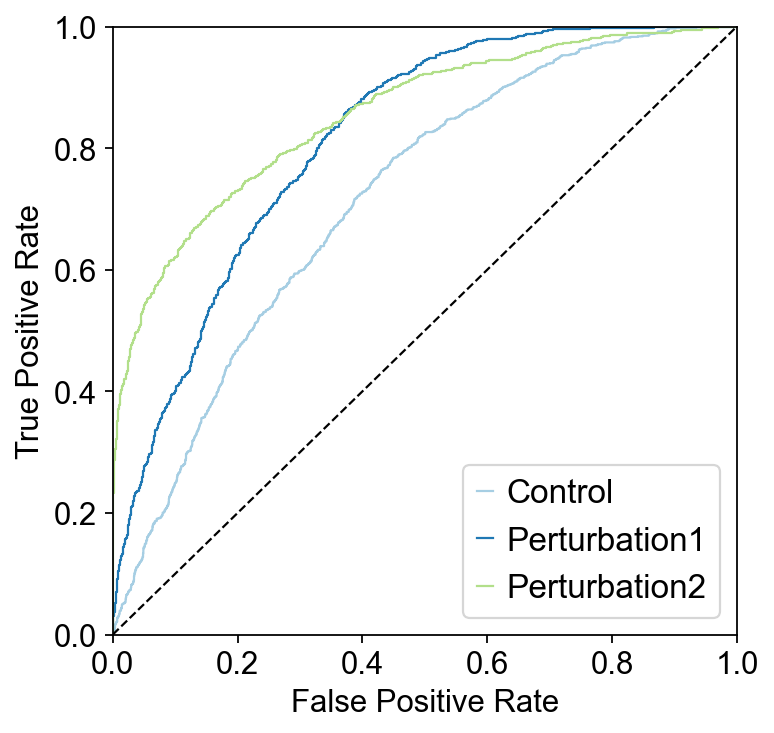

In [27]:
plot_adversarial_classifier_roc(
    adata=adata,
    perturbation_key=perturbation_key,
)

## Attention maps